#### MLP character-level language model using n number of characters as context
This notebook will create and train a Multi-Layer Perceptron on n number of characters as context. 

The notebook follows the paper `Bengio et al. 2003 MLP language model paper (pdf)`
 ```https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf```


This paper works with words instead of characters, and the context size is 3; i.e, a combination of 3 words is used as context to predict the next word. 

However, we will be building a character level model with context size of 3; i.e, a combination of 3 characters will be predicting the next single character.

The embedding size in the paper is 30. We will start by a size of 2 since our vocab is only 27 characters as opposed to 17000 words used in the paper. 

Structure of the MLP is as follows: 



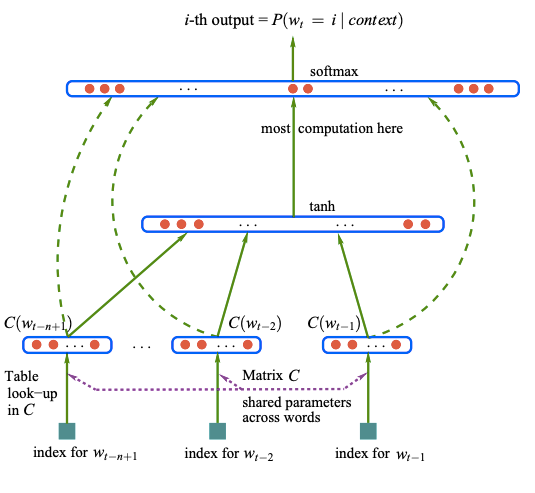

**C** stores the embeddings of characters. They are initialized randomly at the beginning and then optimized during training. The purpose of C is to provide the embedding of an input character.  Based on how we retrieve these embeddings, C can be interpreted in two ways:

1. As a lookup table:

We simply index the embeddings of characters based on the character index. Example: `e` has index 5. So we can simply index the embedding of 5 by doing C[5]. So essentially, we are just looking up or pluckng out a specidif embedding from the table C.

2. As the first layer of the neural net

Another way of getting the same results as point 1 is to do dot product between C and a one hot representation of the input sequence. Matrix multiplication makes sure that we only get the embeddings for the characters given as input, all the remaining values become 0.

Since dot product + bias and a nonlinear function like tanh or relu constitute a neuron, we can simply say that the embedding layer is the first layer of the neural net with no non linearity and bias.


In [1]:
import torch
import torch.nn.functional as F
import random
random.seed(42)


## Data Preprocessing
1. Read the names from the dataset
2. Create a vocabulary of characters
3. Create a training set of bigrams (x,y)
4. Convert the training set of bigrams into one-hot encoded vectors

In [2]:
# Load a list of names from the dataset (each name on a new line)
words = open("data/names.txt", 'r').read().splitlines()
print(words[:3])
print(f"total number of names: {len(words)}")

['emma', 'olivia', 'ava']
total number of names: 32033


### 2. Create a vocabulary of characters

In [3]:
# Build vocabulary of characters from all names
vocab = sorted(set("".join(words)))

# Add '.' as the start/end token, mapped to index 0
# create a mapping from characters to integers
stoi = {s: i+1 for i, s in enumerate(vocab)}
stoi['.'] = 0
# create a mapping from integers to characters
itos = {i: s for s, i in stoi.items()}
print(itos)
vocab_size = len(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### 3. Create a training set of bigrams (x,y)

#### Building Dataset

Length of context = 3 characters

Output = 1 character

In [4]:
block_size = 3 # context length
X, Y = [], [] # examples, labels

for w in words[:5]:
    print(w)
    context = [0] * block_size # setting context to a list of 0s because every word will have the first example as "[. . .]" 
    for ch in w + ".":
        ix = stoi[ch]
        Y.append(ix)
        X.append(context)
        print("".join(itos[i] for i in context), "---->", itos[ix], stoi[itos[ix]])
        context = context[1:] + [ix] # crop and append

# convert from lists to tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ----> e 5
..e ----> m 13
.em ----> m 13
emm ----> a 1
mma ----> . 0
olivia
... ----> o 15
..o ----> l 12
.ol ----> i 9
oli ----> v 22
liv ----> i 9
ivi ----> a 1
via ----> . 0
ava
... ----> a 1
..a ----> v 22
.av ----> a 1
ava ----> . 0
isabella
... ----> i 9
..i ----> s 19
.is ----> a 1
isa ----> b 2
sab ----> e 5
abe ----> l 12
bel ----> l 12
ell ----> a 1
lla ----> . 0
sophia
... ----> s 19
..s ----> o 15
.so ----> p 16
sop ----> h 8
oph ----> i 9
phi ----> a 1
hia ----> . 0


In [5]:
print(X[:10])
print(Y[:10])

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22]])
tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9])


In [6]:
print(X.shape, X.dtype) # we have created 32 examples from 5 inputs
print(Y.shape, Y.dtype)

torch.Size([32, 3]) torch.int64
torch.Size([32]) torch.int64


## Create a Neural net that takes the Examples in X and predicts the next character using Y


#### 1. Build the Lookup table "C". This is the EMBEDDING table.

Embeddings tell us how closely related words/characters are to each other. They store the semantic meaning of words/characters.

Since our vocabulary is not that big, we can embed  each character in a 2 dimensional space, i.e with two integers.

We can initialize these embeddings randomly, and their values will be optimized during the training process.

The shape of the lookup table or the Embedding table will be (27, 2) because we are representing each character in 2 dimensions and there are 27 possible characters.

These embeddings will be used to embed the input. So we will be embedding each example in X.



In [7]:
# randomly generating C (the embedding table) with vocab_size (27) number of rows and 2 dimenstions
C = torch.randn((vocab_size,2))
C

tensor([[-0.6613, -0.4423],
        [ 0.5575,  0.6815],
        [ 1.2161, -1.3362],
        [-0.1897,  1.2352],
        [ 1.0918,  0.6084],
        [-1.3239,  2.3320],
        [-1.8003,  1.4778],
        [-0.6176, -1.1007],
        [ 0.2760,  1.6183],
        [ 0.3327, -0.4732],
        [ 0.5657,  0.2209],
        [ 0.1383, -0.5528],
        [ 0.3738, -0.2703],
        [-0.7260,  0.4350],
        [-0.8030,  0.7203],
        [ 1.6449,  0.7118],
        [-0.0218, -0.3021],
        [ 0.8486,  1.2012],
        [ 0.5995, -0.1997],
        [-1.1583, -0.0226],
        [-0.7170,  0.6353],
        [-0.8289, -0.5064],
        [-0.6342, -0.9793],
        [ 0.6625,  1.5593],
        [ 0.3739, -0.5064],
        [-2.1807,  0.1166],
        [ 1.3258, -0.3771]])

#### Embed the Input X
We need to embed every example in X, where each example has 3 integers. For example, the first three examples of "emma" are 
    ``` [ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13]
    ```
    
We need to embed every example, each example is a list. 

Let's look at embedding a single integer first instead of a list of integers. 

One way to embed is by simple indexing C. 

Suppose we want the embedding for the 5th character, C[5] gives us a 2D tensor. It is simply plucking out the 5th row of C.


In [8]:
# index C to get the embedding
C[5]


tensor([-1.3239,  2.3320])

We can index a list in the same way

In [9]:
C[[0,0,5]]

tensor([[-0.6613, -0.4423],
        [-0.6613, -0.4423],
        [-1.3239,  2.3320]])

A second way is to take the dot product of the one hot encoded index and the look up table C.

One hot form of 5 will look like this with only the 5th bit as 1:

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

The dot product will pluck out the 5th row of C as all the other rows will be set to 0.



In [10]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-1.3239,  2.3320])

Pytorch can do the same for a list by one hot encoding a list

In [11]:
F.one_hot(torch.tensor([0,0,5]), num_classes=27).float() @ C

tensor([[-0.6613, -0.4423],
        [-0.6613, -0.4423],
        [-1.3239,  2.3320]])

So we can embed all the examples in X either by indexing or by one hot encoding every example.

In [ ]:
# embedding by matmul
(F.one_hot(X, num_classes=27).float() @ C)[0:3] # explicitly casting the one hot vector to float since C has float values

tensor([[[-0.6613, -0.4423],
         [-0.6613, -0.4423],
         [-0.6613, -0.4423]],

        [[-0.6613, -0.4423],
         [-0.6613, -0.4423],
         [-1.3239,  2.3320]],

        [[-0.6613, -0.4423],
         [-1.3239,  2.3320],
         [-0.7260,  0.4350]]])

For simplicity, we can use the index method.

In [13]:
emb = C[X]
print(emb[0:3])
print(emb.shape)

tensor([[[-0.6613, -0.4423],
         [-0.6613, -0.4423],
         [-0.6613, -0.4423]],

        [[-0.6613, -0.4423],
         [-0.6613, -0.4423],
         [-1.3239,  2.3320]],

        [[-0.6613, -0.4423],
         [-1.3239,  2.3320],
         [-0.7260,  0.4350]]])
torch.Size([32, 3, 2])


The shape of the embeddings for X is (32, 3, 2) where 32 is the number of examples, 3 is the number of rows in each example, and 2 is the number pf columns in each example. Number of rows == 3 because we use 3 as the context length and number of cols == 2 since we are embedding in a 2D space.

#### 2. First Hidden Layer

The layer after the embedding layer is the first hidden layer. We can have many layers but the paper used a single layer only.

This layer will take the output of the embeddings layer (emb) as input.

The embedding layer will take input of (32,3), and the output of emb will be of (32,3,2) as shown above. Since each character will be represented with 2 values, and one example consists of 3 characters, the total number of inputs (values going into the hidden layer) is 6. So we initialize a weight matrix having 6 rows, and n number of columns (say 100). Each column can be interpreted as a neuron. So a weight matrix with shape (6, 100) will mean 100 neurons with each neuron having 6 weights/connections. 

We will need as many bias values as the number of neurons since each neuron has one bias. 

In [14]:
W1 = torch.randn((6, 100)) # 6 = number of characters * embedding size
b1 = torch.randn(100)

Now the shape of emb is (32,3,2) and that of W1 is (6,100). We cannot do a dot product between the two. We somehow need to concatenate the rows of each example in the emb matrix to make the shape (32,6). That way, W1 with shap (6, 100) and emb with shape (32, 6) can have a dot product. 

We can reduce the shape of (32,3,2) to (32, 6), if we concatenate the rows of each example. So consider a single example. It will have a shape of (1,3,2). For example:

```
[[ 0.4442,  0.2604],
[ 0.4442,  0.2604],
[ 0.4442,  0.2604]]
```

We need to transorm the above (3, 2) vector into this:
```[0.4442,  0.2604,  0.4442,  0.2604,  0.4442,  0.2604]```

This will have a shape of (6)

This can be done by using the `view` method in pythod, which will simply change the view or the placement of values into a new shape without creating a different matrix in memory. This is because a pytorch tensor is always saved as a 1D tensor, regardless of its actual shape. Callimg the view method on top of it presents the tensor in the specified shape.

So now we can calculate the hidden state h i.e the dot product + b and non linearity.

In [15]:
h = emb.view(32,6) @ W1 + b1
# To avoid hardcoding so we can work with any sixe of emb
# We can use emb.shape[0] or -1
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) # emb.shape = (32, 3, 2)
print(h.shape)

torch.Size([32, 100])


The addition of bias will work because the shape of `emb.view(emb.shape[0], 6) @ W1` is (32, 100), and that of bias is (100).
So by broadcasting rules in pytorch:

Right align shape:

32, 100

    100
_________

Put 1 where the shape is empty

32, 100

1,  100
_________

Now the bias vector with shape (1, 100) will be replicated 32 times and the corresponding row of the dot product (32, 100) will be added to the bias element wise.

### 3. The Final Layer (Output Layer)

This layer will take the output of the hidden layer, the hidden state (h), as the input with shape (32, 100). So the weight matrix for this layer will have 100 rows as the input will be 100 (i.e there are 100 values for every example. so the input is 100).

Since this is the final (output) layer, it should output the prob distribution of 27 characters, i.e it should output 27 values. So the number of neurons (columns in the weight matrix) will be 27.

In [16]:
W2 = torch.randn((100,vocab_size))
b2 = (27)

### 4. Do the Forward Pass

Now since the output layer is the final/last layer, it is responsible for giving the probability distribution of all the 27 characters. So we will do what we did for the single layers neural net. 

That is the forward pass:

1. calculate logits (log-counts) ----> this is the dot product same as we did for the hidden layer. In the fonal layer it is known as logits

2. counts (exp of logits)

3. Normalize

2 and 3 are softmax

In [17]:
logits = h @ W2 + b2
counts = torch.exp(logits)
probs = counts / counts.sum(dim=1, keepdim=True)
probs.shape

torch.Size([32, 27])

In [18]:
probs[0].sum()

tensor(1.)

### 5. Calculate Loss

Now that we have the predicted prob distributions for the next character, we can use Y (the actual output) to calculate loss.

Loss is the Negtive Loglikelihood.

First, pluck out the likelihood/prob assigned to the correct output by the model. We will use indexing instead of the dot product method.

In [19]:
likelihood = probs[torch.arange(32), Y]
likelihood, likelihood.shape

(tensor([2.0493e-06, 1.1079e-07, 6.8052e-07, 2.2441e-07, 8.3035e-05, 1.8869e-12,
         2.6845e-12, 1.6379e-07, 2.5213e-08, 9.0283e-10, 8.8488e-10, 3.1013e-09,
         3.2944e-12, 1.9677e-11, 9.3162e-07, 6.6405e-04, 3.2519e-11, 2.1060e-02,
         4.9250e-09, 7.2857e-11, 4.5742e-11, 1.2963e-13, 2.6363e-12, 4.4259e-03,
         4.2263e-09, 7.0316e-07, 2.1857e-10, 4.7839e-13, 8.1114e-11, 1.8790e-03,
         2.5123e-14, 2.0828e-04]),
 torch.Size([32]))

The likelihoods for the correct output are not very good. There are probs as low as 4.1839e-07. A good model would predict these probs to be 1 or closer to 1. These are the probs generated by the model using the random weights. Training will make these probs get closer to 1 by reducing loss.

In [20]:
print(-likelihood.log())
loss = -likelihood.log().mean()

tensor([13.0980, 16.0156, 14.2004, 15.3098,  9.3962, 26.9961, 26.6435, 15.6247,
        17.4959, 20.8255, 20.8456, 19.5914, 26.4388, 24.6516, 13.8863,  7.3172,
        24.1492,  3.8604, 19.1289, 23.3425, 23.8080, 29.6741, 26.6616,  5.4203,
        19.2819, 14.1677, 22.2439, 28.3684, 23.2352,  6.2770, 31.3150,  8.4766])


In [21]:
loss

tensor(18.6796)

#### Summarizing the forward Pass and putting it altogether

1. Generate lookup table C for embeddings
2. Generate Ws and Bs for all the layers
3. Index embeddings to calculate emb
4. Hidden state
5. Logits
6. Counts
7. Probs
8. Loss

In [22]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [23]:
# initialize params
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]
# total number of parameters
total_params = sum(p.nelement() for p in parameters)
print(f"total number of parameters in model: {total_params}")

total number of parameters in model: 3481


In [24]:
for p in parameters:
    print (p.dtype)

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32


In [25]:
# forward pass
emb = C[X] # get embeddings for inputs
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden state (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)

# calculate loss
likelihood = probs[torch.arange(Y.shape[0]), Y]
loss = -likelihood.log().mean()
loss


tensor(17.7697, grad_fn=<NegBackward0>)


The code to calculate counts, probs and loss actually calculates the cross entropy (which is NLL). Calculating NLL like above is inefficient and should never be used in practice. It can be replaced by pytorch's cross entropy function. 

```Cross Entropy```
The formula for cross entropy is:
$$
L = -\frac{1}{N} \sum_{i=1}^{N} \log(p_i)
$$

Where:

***N***: The number of samples (data points) in the batch or dataset.

​
***Pi***: The predicted probability for the correct class of the i-th sample.

``` 
Why we should not calculate counts, probs, and loss separately?
``` 
1. Vectors for counts, probs and loss are created separately in the memory which is not efficient
2. Going through all the 3 steps separately makes the backward pass more complex
3. Logits can take big positive values while training, e.g 100. When we calculate counts by taking exp, exp of a big positive number run out of range of floating point number and we get inifity. This produces `nan` values in probs. 

```
Why Cross Entropy?
```
1. Using cross-entropy instead does not create vectors separately for every step and the expresseion for backward pass (the gradient) is much simpler.
2. Cross-entropy also takes care of very big values in logits by subtracting every value in the logits tensor by the largest value in the tensor. This makes the largest number 0 and all the other number negative. This does not change the prob distribution later on when probs is calculated, but it does take care of getting `nan` values in probs because of big values in logits.

Modified forward pass with cross-entropy loss

In [26]:
 # forward pass
emb = C[X] # get embeddings for inputs
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden state (32, 100)
logits = h @ W2 + b2 # (32, 27)

# calculate loss
loss = F.cross_entropy(logits, Y)
loss


tensor(17.7697, grad_fn=<NllLossBackward0>)

### 6. Backward Pass
0. Set requires_grad param for every param to True if it was not set to True during the initiation of these params
1. Set the gradients for all parameters to None (equivalent to 0 in pytorch)
2. Call backward method on loss
3. Update weights

In [27]:
# run a single backward pass
lr = 0.1

# set grads to None
for p in parameters:
    p.grad = None

# run backward on loss to get the grads for loss wrt to every param
loss.backward() 

# update using gradient descent
for p in parameters:
    # p.data = p.data - (lr * p.grad)
    p.data += -lr * p.grad

#### Combining the forward and backward pass for running n iterations - Overfitting on a batch of 32 examples

In [28]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [29]:
# initialize params
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

total_params = sum(p.nelement() for p in parameters)
print(f"total number of parameters: {total_params}")

total number of parameters: 3481


In [30]:
n = 1000 # num of epochs/iterations
lr = 0.1
for i in range(n):
    # forward pass
    emb = C[X] # get embeddings for inputs
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden state (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    # calculate loss
    loss = F.cross_entropy(logits, Y)

    # backward pass
    # set grads to None
    for p in parameters:
        p.grad = None

    # run backward on loss to get the grads for loss wrt to every param
    loss.backward() 

    # update params with the new grads
    for p in parameters:
        # p.data = p.data - (lr * p.grad)
        p.data += -lr * p.grad
        
print(f"loss: {loss}")

    

loss: 0.2561391294002533


We were able to achieve a low loss of 0.25 because we were using just 32 examples to train a model of 3481 parameters, and not the entire dataset. Training on this batch (32 examples) of the dataset, we overfit the model on this batch and that's why get good loss because of having so many params for very few examples.

```
Why we don't get a loss of zero
```
when predicting logits, a good model should have the highest value of the logit at the index of the correct output. That is, if we extract the index at which the logits for each training example has the highest value, these indices should correspond to the indicies stored in Y.

In [31]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [32]:
logits.max(dim=1).indices


tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

When we compare the two, we see that the model has often mixed up predictions for indices 1, 5, 9, 15, 19. This is because, for every new word, the first example is 

`[. . .]` and in the dataset the output can be any of [e, o, a, i, s]. So when the input is `[. . .]`, the model gets confused as which one of `[e, o, a, i, s]` to predict. Thats why we do not get a loss of zero and not completely OVERFIT. 

However, for the examples where unique inputs lead to unique outputs, we OVERFIT and produce correct predictions.

| Name      | Trigram | Next Char | Code/Label |
|-----------|---------|-----------|------|
| emma      | ...     | e         | 5    |
| emma      | ..e     | m         | 13   |
| emma      | .em     | m         | 13   |
| emma      | emm     | a         | 1    |
| emma      | mma     | .         | 0    |
| olivia    | ...     | o         | 15   |
| olivia    | ..o     | l         | 12   |
| olivia    | .ol     | i         | 9    |
| olivia    | oli     | v         | 22   |
| olivia    | liv     | i         | 9    |
| olivia    | ivi     | a         | 1    |
| olivia    | via     | .         | 0    |
| ava       | ...     | a         | 1    |
| ava       | ..a     | v         | 22   |
| ava       | .av     | a         | 1    |
| ava       | ava     | .         | 0    |
| isabella  | ...     | i         | 9    |
| isabella  | ..i     | s         | 19   |
| isabella  | .is     | a         | 1    |
| isabella  | isa     | b         | 2    |
| isabella  | sab     | e         | 5    |
| isabella  | abe     | l         | 12   |
| isabella  | bel     | l         | 12   |
| isabella  | ell     | a         | 1    |
| isabella  | lla     | .         | 0    |
| sophia    | ...     | s         | 19   |
| sophia    | ..s     | o         | 15   |
| sophia    | .so     | p         | 16   |
| sophia    | sop     | h         | 8    |
| sophia    | oph     | i         | 9    |
| sophia    | phi     | a         | 1    |
| sophia    | hia     | .         | 0    |

#### Optimize the model on the full dataset

In [33]:
# create the dataset for all the inputs
block_size = 3 # context length
X, Y = [], [] # examples, labels

for w in words:
    # print(w)
    context = [0] * block_size # setting context to a list of 0s because every word will have the first example as "[. . .]" 
    for ch in w + ".":
        ix = stoi[ch]
        Y.append(ix)
        X.append(context)
        # print("".join(itos[i] for i in context), "---->", itos[ix], stoi[itos[ix]])
        context = context[1:] + [ix] # crop and append

import torch
X = torch.tensor(X)
Y = torch.tensor(Y)

print(X.shape, Y.shape)

torch.Size([228146, 3]) torch.Size([228146])


In [34]:
# Nothing changes here
# initialize params
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

total_params = sum(p.nelement() for p in parameters)
print(f"total number of parameters: {total_params}")

total number of parameters: 3481


In [35]:
n = 10 # num of epochs/iterations
lr = 0.1
for i in range(n):
    # forward pass
    emb = C[X] # get embeddings for inputs (228146, 3, 2 )
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden state 
    logits = h @ W2 + b2 # 

    # calculate loss
    loss = F.cross_entropy(logits, Y)
    print(f"loss: {loss}")

    # backward pass
    # set grads to None
    for p in parameters:
        p.grad = None

    # run backward on loss to get the grads for loss wrt to every param
    loss.backward() 

    # update params with the new grads
    for p in parameters:
        # p.data = p.data - (lr * p.grad)
        p.data += -lr * p.grad
        

    

loss: 19.505226135253906
loss: 17.084484100341797
loss: 15.776531219482422
loss: 14.833340644836426
loss: 14.002605438232422
loss: 13.253263473510742
loss: 12.57991886138916
loss: 11.983102798461914
loss: 11.47049331665039
loss: 11.05185604095459


### Training on minibatches - Minibatch Stochastic Gradient Descent

Working on all the examples takes more time to train as we forward and backward all the 32000 inputs. Also, for large datasets, not all the examples can fit into memory at once. In practice, the dataset is divided into minibatches for training and params are updated for these minibatches.

We decide a size of the minibatch, say 32, then randomly select 32 examples from the dataset and run forward, backward and update on the examples in that minibatch.

The current setup looks like this:
1. X[ix] and Y[ix] extract the inputs/targets for just 32 examples.
2. Each iteration processes a new random minibatch of 32 examples.
3. The loss (F.cross_entropy(logits, Y[ix])) is computed only for the current minibatch. It does not reflect the loss of the entire dataset.
When you print loss, it shows the loss for those 32 examples only.
```



## Train for t iterations with a minibatch size of 32

In [36]:
# randomly selecting 32 examples for a minibatch of size 32
# train minibatches
t = 1000
for i in range(t):
    # forward pass on minibatches of 32
    ix = torch.randint(0, X.shape[0], (32,)) # X.shape[0] = 228146 # creates 32 random indices between 0 and the total number of examples

    emb = C[X[ix]] # get embeddings for inputs (32, 3, 2 )
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden state 
    logits = h @ W2 + b2 # 

    # calculate loss
    loss = F.cross_entropy(logits, Y[ix])
    print(f"loss on batch {i}: {loss}")

    # backward pass
    # set grads to None
    for p in parameters:
        p.grad = None

    # run backward on loss to get the grads for loss wrt to every param
    loss.backward() 

    # update params with the new grads
    for p in parameters:
        # p.data = p.data - (lr * p.grad)
        p.data += -0.1 * p.grad

loss on batch 0: 10.381791114807129
loss on batch 1: 11.711999893188477
loss on batch 2: 10.93283462524414
loss on batch 3: 9.969021797180176
loss on batch 4: 9.248031616210938
loss on batch 5: 9.259753227233887
loss on batch 6: 9.077272415161133
loss on batch 7: 7.909458160400391
loss on batch 8: 8.995230674743652
loss on batch 9: 8.980300903320312
loss on batch 10: 8.80314826965332
loss on batch 11: 8.623515129089355
loss on batch 12: 7.05102014541626
loss on batch 13: 6.966073036193848
loss on batch 14: 7.399805068969727
loss on batch 15: 8.967135429382324
loss on batch 16: 8.995716094970703
loss on batch 17: 8.460627555847168
loss on batch 18: 5.03809118270874
loss on batch 19: 7.000865459442139
loss on batch 20: 5.701440334320068
loss on batch 21: 5.476085186004639
loss on batch 22: 6.69602108001709
loss on batch 23: 6.435730457305908
loss on batch 24: 6.456608772277832
loss on batch 25: 5.6525678634643555
loss on batch 26: 7.838639736175537
loss on batch 27: 5.904420852661133
los

loss on batch 111: 2.801535129547119
loss on batch 112: 3.3941256999969482
loss on batch 113: 3.3650381565093994
loss on batch 114: 2.8078417778015137
loss on batch 115: 2.756265640258789
loss on batch 116: 3.632307767868042
loss on batch 117: 2.8813328742980957
loss on batch 118: 3.6971311569213867
loss on batch 119: 3.487253189086914
loss on batch 120: 3.2213494777679443
loss on batch 121: 3.072232723236084
loss on batch 122: 3.9077908992767334
loss on batch 123: 3.194122076034546
loss on batch 124: 2.8534438610076904
loss on batch 125: 3.377297878265381
loss on batch 126: 3.5252857208251953
loss on batch 127: 3.206101417541504
loss on batch 128: 3.5451483726501465
loss on batch 129: 3.2603042125701904
loss on batch 130: 3.3176233768463135
loss on batch 131: 2.996607542037964
loss on batch 132: 3.213240623474121
loss on batch 133: 3.2305657863616943
loss on batch 134: 3.075169801712036
loss on batch 135: 3.262578010559082
loss on batch 136: 3.4686787128448486
loss on batch 137: 2.908

In [37]:
print(loss.item())

2.6069366931915283


Each individual loss is loss calculated on a single batch, not the entire training set.

`Fluctuating Loss`:
Since each minibatch is a different random subset, the loss will jump up/down between iterations. This is normal! It reflects how "hard" or "easy" that particular batch was for the model. Loss fluctuates because batches aren't equally difficult

`Approximation of True Loss`:
The average loss over many minibatches (e.g., 100) will roughly approximate the loss over the full dataset, but it’s not exact.

`Gradient Updates`:
Each backward pass (loss.backward()) computes gradients only for the current minibatch, and the parameters are updated based on those gradients.

### Epochs vs. Iterations: Crucial Difference



#### Definitions
| Term        | Meaning                                                                 | Your Code Equivalent                          |
|-------------|-------------------------------------------------------------------------|-----------------------------------------------|
| **Iteration** | One update step using a single minibatch                              | `for i in range(t)`  → t = 100, 100 updates using 100 minibatches         |
| **Epoch**    | One full pass through the *entire* dataset                             | Not implemented in current code              |

#### Current Code Behavior
- **Runs**: 100 training steps (iterations)
- **Each step**: Uses 1 random minibatch of 32 examples
- **Total examples processed**: `100 × 32 = 3,200 examples`
- **Dataset size**: 228,146 examples
- **Data coverage**: Only **1.4%** of full data seen (3200/228146)

This will update the model weights 100 times

#### What is an Epoch?
- **1 epoch** = Seeing every training example **once**
- **For your dataset**:
  - Total examples per epoch: 228,146
  - At batch size 32: `228,146 / 32 ≈ 7,130 iterations` needed per epoch

#### Key Comparison
| Metric          | Current Code (100 iters) | 1 Full Epoch      |
|----------------|-------------------------|------------------|
| Examples Seen  | 3,200                  | 228,146          |
| % Data Covered | 1.4%                   | 100%             |
| Batch Updates  | 100                    | ~7,130           |

#### Implications
the code above is not running epochs, it is only running iterations of minibatches.
Your model needs **many more iterations** to properly learn from all data!

### Evaluate the Loss on the entire dataset
```Why This Matters```

- Minibatch Training Loss (what you printed during training):

    - Only shows performance on tiny random samples (32 examples)

    - Jumpy and unreliable - some batches are easier than others

- Full Dataset Loss (what this code calculates):

    - Shows the REAL performance

    - The true test of whether your model actually learned anything useful

In [38]:
# evaluate the loss on the entire dataset
emb = C[X] # get embeddings for inputs (28k, 3, 2 )
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden state 
logits = h @ W2 + b2 #  

# calculate loss
loss = F.cross_entropy(logits, Y)
print(f"loss on the entire training set: {loss}")


loss on the entire training set: 2.7351768016815186


### Training Diagnostics Table

| Minibatch Loss | Full Dataset Loss | Pattern           | Diagnosis                          | Recommended Actions                 |
|----------------|-------------------|-------------------|------------------------------------|-------------------------------------|
| High (~2.0)    | High (~2.0)       | ❌ Not Learning    | Model isn't capturing patterns     | 1. Check data loading<br>2. Verify model architecture<br>3. Increase training time |
| High (~2.0)    | Much Higher (~3.5)| 🎯 Batch Overfit   | Memorizing batches, not generalizing | 1. Increase batch size<br>2. Reduce learning rate<br>3. Add dropout |
| Decreasing     | Still High        | ⏳ Needs Training  | Learning but incomplete            | 1. Train more epochs<br>2. Try Adam optimizer |
| Low (~0.3)     | Similarly Low (~0.4)| ✅ Healthy       | Properly learning                  | Continue monitoring                 |
| Very Low (~0.1)| Much Higher       | 🚨 Overfitting    | Memorizing training data           | 1. Add L2 regularization<br>2. Get more data<br>3. Simplify model |


#### How to Determine a Good Learning Rate

Select a reasonable search range where for the lowest value of LR, the loss does not reduce TOO slowly and for the highest value of LR, the loss  overshoots.

Suppose our range of LR is between -0.001 and -1 (p.data += -(lr) * p.grad)

At -0.001 the model converges very slowly and at -1 the loss explodes. So we can assume that our right learning rate that is not too slow or too fast in in this range.

In [39]:
# initialize LRS using logarithmic scale instead of linear scale
lr_exp = torch.linspace(-3, 0 , 1000) # 0.001 = e^-3, 1 = e^0, 1000 = the number of steps we want to have between 0.001 and 1
lrs = 10**lr_exp

print(lr_exp[:2])
print(lrs[:2])

tensor([-3.0000, -2.9970])
tensor([0.0010, 0.0010])


In [40]:
# initialize params
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

total_params = sum(p.nelement() for p in parameters)
print(f"total number of parameters: {total_params}")

for p in parameters:
    p.requires_grad = True

total number of parameters: 3481


In [41]:
# randomly selecting 32 examples for a minibatch of size 32
# train minibatches
t = 1000
lri = []
lossi = []
for i in range(t):
    # forward pass on minibatches of 32
    ix = torch.randint(0, X.shape[0], (32,)) # X.shape[0] = 228146 # creates 32 random indices between 0 and the total number of examples

    emb = C[X[ix]] # get embeddings for inputs (32, 3, 2 )
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden state 
    logits = h @ W2 + b2 # 

    # calculate loss
    loss = F.cross_entropy(logits, Y[ix])
    # print(f"loss on batch {i}: {loss}")

    # backward pass
    # set grads to None
    for p in parameters:
        p.grad = None

    # run backward on loss to get the grads for loss wrt to every param
    loss.backward() 
    lr = lrs[i]
    
    # update params with the new grads
    for p in parameters:
        # p.data = p.data - (lr * p.grad)
        p.data += -lr * p.grad

    lri.append(lr_exp[i])
    lossi.append(loss.item())
        

    


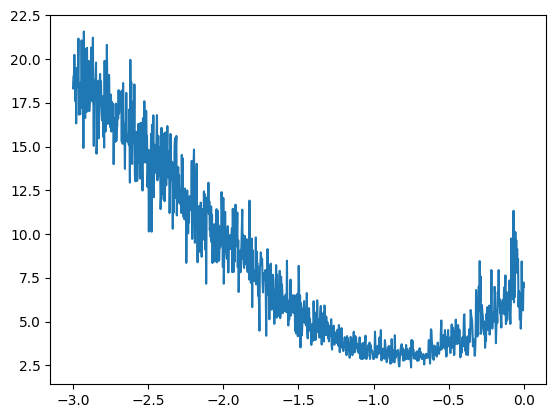

In [42]:
import matplotlib.pyplot as plt

plt.plot(lri, lossi)

X-Axis: Exponent of the LR

Y-Axis: Loss

AT the left most side of the graph, the LR is very low, starting from e^-3 (0.001) which is too small and thus the loss is high (between 20 and 22).

The loss decreases as we go towrads a higher LR and explodes after the exponent value of -0.5. The most stable the loss is around e^-1.0 (0.1). So we can say -0.1 is a safe bet for the LR.


#### Training with Learning Rate Decay


Now that we have found a suitable LR, we can run for more iterations using the learning rate. Once we have trained for a reasonale time, say 100,000 iterations, we can decay the learning rate (i.e decreasing by 10x) for the later stages of training. The idea is to take smaller steps so we reach the global minimum and don't overshoot. 

So you take big steps when you are away from the global minima and you take smaller steps whn you are approaching the global minima. 

Summary:
- Find a decent LR
- Train using that LR for a while
- Train using a decayed LR for a few more steps

In [43]:
# initialize params
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

total_params = sum(p.nelement() for p in parameters)
print(f"total number of parameters: {total_params}")

for p in parameters:
    p.requires_grad = True

total number of parameters: 3481


In [44]:
# Training
t = 100000
lri = []
lossi = []
for i in range(t):
    # forward pass on minibatches of 32
    ix = torch.randint(0, X.shape[0], (32,)) # X.shape[0] = 228146 # creates 32 random indices between 0 and the total number of examples

    emb = C[X[ix]] # get embeddings for inputs (32, 3, 2 )
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden state 
    logits = h @ W2 + b2 # 

    # calculate loss
    loss = F.cross_entropy(logits, Y[ix])
    # print(f"loss on batch {i}: {loss}")

    # backward pass
    # set grads to None
    for p in parameters:
        p.grad = None

    # run backward on loss to get the grads for loss wrt to every param
    loss.backward() 
    lr =0.1
    
    # update params with the new grads
    for p in parameters:
        # p.data = p.data - (lr * p.grad)
        p.data += -lr * p.grad

print(loss.item())      

2.3350913524627686


In [45]:
# Evaluating
# evaluate the loss on the entire dataset
emb = C[X] # get embeddings for inputs (28k, 3, 2 )
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden state 
logits = h @ W2 + b2 #  

# calculate loss
loss = F.cross_entropy(logits, Y)
print(f"loss on the entire training set: {loss}")


loss on the entire training set: 2.3072845935821533


#### Decay the LR from 0.1 to 0.01 and train for 10000 iterations

In [46]:
# Training
t = 10000
for i in range(t):
    # forward pass on minibatches of 32
    ix = torch.randint(0, X.shape[0], (32,)) # X.shape[0] = 228146 # creates 32 random indices between 0 and the total number of examples

    emb = C[X[ix]] # get embeddings for inputs (32, 3, 2 )
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden state 
    logits = h @ W2 + b2 # 

    # calculate loss
    loss = F.cross_entropy(logits, Y[ix])
    # print(f"loss on batch {i}: {loss}")

    # backward pass
    # set grads to None
    for p in parameters:
        p.grad = None

    # run backward on loss to get the grads for loss wrt to every param
    loss.backward() 
    lr =0.01
    
    # update params with the new grads
    for p in parameters:
        # p.data = p.data - (lr * p.grad)
        p.data += -lr * p.grad

print(loss.item())      

2.717958450317383


In [ ]:
# Evaluating
# evaluate the loss on the entire dataset
emb = C[X] # get embeddings for inputs (28k, 3, 2 )
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden state 
logits = h @ W2 + b2 #  

# calculate loss
loss = F.cross_entropy(logits, Y)
print(f"loss on the entire training set: {loss}") 

loss on the entire training set: 2.2571065425872803


#### Comparison with the bigram model using a linear layer nn
The loss for the bigram was 2.45 but using an MLP we have reduced the loss to 2.25, surpassing the performance. 

SO we cab say that we have a better model as compared to the bigram model.

### Does a good loss always mean a good model?

As the num of parameters of a model grow by adding neurons  , that is model's complexity increases, it becomes more and more powerful to memorize the training data, i.e, it OVERFITS on the training data. 

So the loss might be as low as 0 on the training data but it might not be able to produce any new data (in case of makemore) and if you evaluate the loss on some unseen data, the loss will be very high.  

### Training, Dev/Validation, Test Splits

- Training Split:
    - 80% of the training set
    - Used to optimize the params of the model using backprop

- Dev/Validation Split:
    - 10% of the training et
    - Used to tune the hyperparams (e.g. size of the hidden layer, embedding layer, regularization strength, LR,  etc)

- Test Split:
    - Evalaute the performance of the model at the end
    
| Split        | Typical Size | Purpose                          | Key Notes                     |
|--------------|--------------|----------------------------------|-------------------------------|
| **Training** | 70-80%       | Model parameter learning         | Largest chunk for backprop    |
| **Dev** (Validation) | 10-15% | Hyperparameter tuning            | Acts as "simulated test set"  |
| **Test**     | 10-15%       | Final unbiased evaluation        | Only used ONCE at the end     |

1. Train the model on the test set with a specific set of hyperparams (eg, epochs = 100, lr = 0.1 etc)
2. Evalute the performance on the validation set
3. Repeat the steps 1 and 2 with a different set of hyperparams
4. Find the hyperparams with the least loss on the validation set. These are your final hyperparams
5. Test on the test set

### Build the dataset and train, test and dev splits

In [48]:
def build_dataset(words):
    block_size = 3 # context length
    X, Y = [], [] # examples, labels

    for w in words:
        # print(w)
        context = [0] * block_size # setting context to a list of 0s because every word will have the first example as "[. . .]" 
        for ch in w + ".":
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)
            # print("".join(itos[i] for i in context), "---->", itos[ix], stoi[itos[ix]])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y


import random
random.seed(42)
random.shuffle(words) # shuffle words before creating the dataset

n1 = int(0.8 * len(words)) # number of training examples 80%
n2 = int(0.9 * len(words)) 
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtst, Ytst = build_dataset(words[n2:])



torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [49]:
print(f" number of training examples: {n1}\n number of dev examples: {n2-n1}\n number of test examples: {len(words)-n2}")

 number of training examples: 25626
 number of dev examples: 3203
 number of test examples: 3204


#### Train on the Training Set

In [50]:
# initialize params
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

total_params = sum(p.nelement() for p in parameters)
print(f"total number of parameters: {total_params}")

for p in parameters:
    p.requires_grad = True

total number of parameters: 3481


In [51]:
# Training
t = 30000
# t = 10000
for i in range(t):
    # forward pass on minibatches of 32
    ix = torch.randint(0, Xtr.shape[0], (32,)) # X.shape[0] = 228146 # creates 32 random indices between 0 and the total number of examples

    emb = C[Xtr[ix]] # get embeddings for inputs (32, 3, 2 )
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden state 
    logits = h @ W2 + b2 # 

    # calculate loss
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(f"loss on batch {i}: {loss}")

    # backward pass
    # set grads to None
    for p in parameters:
        p.grad = None

    # run backward on loss to get the grads for loss wrt to every param
    loss.backward() 
    # lr = 0.1
    lr = 0.01
    
    # update params with the new grads
    for p in parameters:
        # p.data = p.data - (lr * p.grad)
        p.data += -lr * p.grad

print(loss.item())  

2.498222827911377


#### Evaluate on the Dev Split 

In [52]:
# Evaluating
# evaluate the loss on the dev split
emb = C[Xdev] # get embeddings for inputs (28k, 3, 2 )
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden state 
logits = h @ W2 + b2 #  

# calculate loss
loss = F.cross_entropy(logits, Ydev)
print(f"loss on the dev set: {loss}")

loss on the dev set: 2.480050563812256


##### ```Run the training cell again now for 10000 iterations instead of 30000 and with a lr decay and evaluate on the dev split again.```

##### ``` Evaluate the loss on the entire training set```

In [53]:
# Evaluating
# evaluate the loss on the entire training set
emb = C[Xtr] # get embeddings for inputs (28k, 3, 2 )
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden state 
logits = h @ W2 + b2 #  

# calculate loss
loss = F.cross_entropy(logits, Ytr)
print(f"loss on the dev set: {loss}")

loss on the dev set: 2.4856553077697754


##### ``` Loss on the training and the dev sets is almost equal so we are not overfitting. However, when the dev and the training losses are the same, it means that the model is not able to memorize (overfit) on the training set, which means the model is underfitting. This indicates that the model is very tiny for the given size of the dataset.```

#### ``` To improve the performance, we need to scale up the size of the neural net. Keep in mind that a bigger neural net takes longer to converge.```

#### Scaling the size of the Neural Net

- The simplest way is to increase the size of the hidden layers (one hidden layer in our model)

In [54]:
# initialize params
# (we go from 100 to 300 neurons in the hidden layer)
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g) 
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

total_params = sum(p.nelement() for p in parameters)
print(f"total number of parameters: {total_params}")

for p in parameters:
    p.requires_grad = True

total number of parameters: 10281


In [55]:
stepi = []
lossi = []

In [56]:
# Training
t = 30000
for i in range(t):
    # forward pass on minibatches of 32
    ix = torch.randint(0, Xtr.shape[0], (32,)) # X.shape[0] = 228146 # creates 32 random indices between 0 and the total number of examples

    emb = C[Xtr[ix]] # get embeddings for inputs (32, 3, 2 )
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden state 
    logits = h @ W2 + b2 # 

    # calculate loss
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(f"loss on batch {i}: {loss}")

    # backward pass
    # set grads to None
    for p in parameters:
        p.grad = None

    # run backward on loss to get the grads for loss wrt to every param
    loss.backward() 
    lr = 0.1
    # lr = 0.01
    # lr = 0.05
    
    # update params with the new grads
    for p in parameters:
        # p.data = p.data - (lr * p.grad)
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.item())

print(loss.item())      


2.3572540283203125


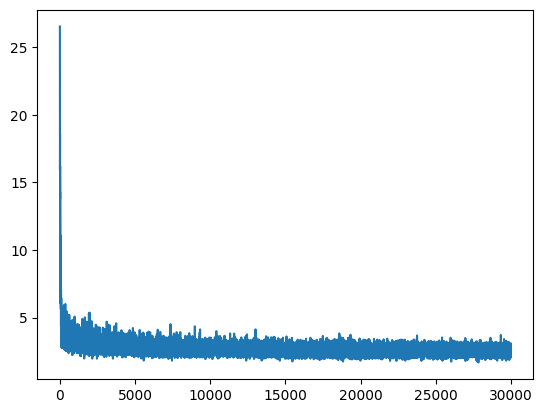

In [57]:
import matplotlib.pyplot as plt
plt.plot(stepi, lossi)

``` The thickness of the loss function is because we are training on minibatches and minibatches create noise ```

In [58]:
# Evaluating
# evaluate the loss on the entire training set
emb = C[Xtr] # get embeddings for inputs (28k, 3, 2 )
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden state 
logits = h @ W2 + b2 #  

# calculate loss
loss = F.cross_entropy(logits, Ytr)
print(f"loss on the dev set: {loss}")

loss on the dev set: 2.4903829097747803


In [59]:
# Evaluate on the dev set

# evaluate the loss on the dev split
emb = C[Xdev] # get embeddings for inputs (28k, 3, 2 )
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden state 
logits = h @ W2 + b2 #  

# calculate loss
loss = F.cross_entropy(logits, Ydev)
print(f"loss on the dev set: {loss}")

loss on the dev set: 2.490330219268799


``` Trying to run more iterations with a decreased learning rate 0.05 by rerunning the training cell```

``` Continue training as we expect to see a decrease in the loss since we have increased the model size. The model should overfit```

``` The model did not overfit by increasing and is still underfitting with the increased size of the hidden layer. The bottle neck could be the size of the embeddings. Maybe we are cramming way too many characters into 2 dims.  ```

#### Increase the size of embeddings
- Also, decreasing the hidden layer to 200

In [60]:
# initialize params
# (we go from 100 to 300 neurons in the hidden layer)
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 20), generator=g)
W1 = torch.randn((60  , 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

total_params = sum(p.nelement() for p in parameters)
print(f"total number of parameters: {total_params}")

for p in parameters:
    p.requires_grad = True

total number of parameters: 18167


In [61]:
stepi = []
lossi = []

In [62]:
# Training
t = 200000
# t = 10000
for i in range(t):
    # forward pass on minibatches of 32
    ix = torch.randint(0, Xtr.shape[0], (32,)) # X.shape[0] = 228146 # creates 32 random indices between 0 and the total number of examples

    emb = C[Xtr[ix]] # get embeddings for inputs (32, 3, 2 )
    h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # hidden state 
    logits = h @ W2 + b2 # 

    # calculate loss
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(f"loss on batch {i}: {loss}")

    # backward pass
    # set grads to None
    for p in parameters:
        p.grad = None

    # run backward on loss to get the grads for loss wrt to every param
    loss.backward() 
    lr = 0.1

    if i >= 100000:
        lr = 0.01
    
    # update params with the new grads
    for p in parameters:
        # p.data = p.data - (lr * p.grad)
        p.data += -lr * p.grad

    
    stepi.append(i)
    lossi.append(loss.log10().item()) # plotting the log of loss to avoid the steep hockey like figure

print(loss.item())      

2.294283866882324


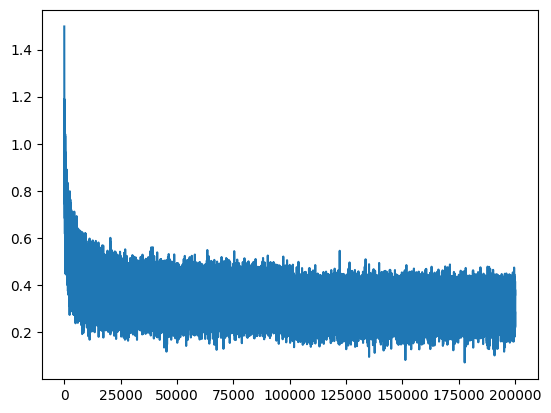

In [63]:
plt.plot(stepi, lossi)

In [64]:
# Evaluating
# evaluate the loss on the entire training set
emb = C[Xtr] # get embeddings for inputs (28k, 3, 2 )
h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # hidden state 
logits = h @ W2 + b2 #  

# calculate loss
loss = F.cross_entropy(logits, Ytr)
print(f"loss on the dev set: {loss}")

loss on the dev set: 2.066542387008667


In [65]:
# Evaluating
# evaluate the loss on the  dev set
emb = C[Xdev] # get embeddings for inputs (28k, 3, 2 )
h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # hidden state 
logits = h @ W2 + b2 #  

# calculate loss
loss = F.cross_entropy(logits, Ydev)
print(f"loss on the dev set: {loss}")

loss on the dev set: 2.1431827545166016


``` Decrease the learning rate by a factor of 10 and run the training cell.```
- after runing many iterations the evaluation loss on train and dev sets should start departing. that is, while both the losses will be decreasing, the loss on the training set will be decreasing more and the difference bewteen the losses of the two splits will become bigger. This is when we can say that the model has started to learn and overfift the training set instead of underfitting.

- In production, you have a set of hyperparameters and you run many experiments and see which set of hyperparams gives the best DEV performance. since that means that your model is able to predict well on unseen data as well.

- Once you have the set of hyperparams that work the best, you evaluate on the TEST set and the test loss is the figure you report in papers and reports to depict the performance of your model.

#### Sample from the model

In [67]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all zeros
    
    while True:
        # Forward pass
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) # hidden layer
        logits = h @ W2 + b2 # output layer
        probs = F.softmax(logits, dim=1) # probability (Same as counts + exp but more optimized like cross entropy)
        
        # Sampling the next character
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        # Update context
        context = context[1:] + [ix]
        out.append(ix)
        
        # Stop if end token (0) is generated
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mona.
kmyanniee.
med.
ryla.
remyan.
emdrlee.
adelynnelin.
shi.
jen.
eden.
sananar.
kayziah.
kamin.
shubvrrahiriel.
kinde.
jennox.
terian.
brence.
ryyloni.
eha.


##### ``` The names produced by the TRIGRAM model are much more name like as compared to the ones produced by the bigram neural net. We can experiment more by taking more characters as context. ```